# Introduction

For this project I am going to use the [Seattle](https://www.kaggle.com/airbnb/seattle) and [Boston](https://www.kaggle.com/airbnb/boston) Airbnb Open Data to solve some business problem using the CRISP-DM Process of:
1. Business Understanding
2. Data Understanding
3. Prepare Data
4. Data Modeling
5. Evaluate the Results
6. Deploy

## Business Understanding
Imagine you are travelling to Seattle or Boston, and trying to book an Airbnb. You may find that the price of those listings varies drastically across (>20%) the week and year. It seems like there are some seasonal patterns and factors that affect the price of those listings. Therefore, I would like to know
1. **What are the busiest times to visit Boston and Seattle? By how much do prices spike?**
2. How well can we predict the price of the listing? Which features affect the price the most?
3. Which kind of host tends to have a better review?

In this notebook, I will start with the first question. For the other questions, they will be available on other notebooks.

## Data Understanding

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

df_calendar_bos = pd.read_csv('./boston/calendar.csv')

df_calendar_sea = pd.read_csv('./seattle/calendar.csv')

In this section, I will analysis the prices difference between the Boston Airbnb and Seattle Airbnb in certain time frames.

In [3]:
df_calendar_bos.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [4]:
df_calendar_sea.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


## Prepare Data
We clean and reformat the data by removing the $ sign from price, extract year,month and days from date. Also, change the availablity to binary.

In [5]:
def reformat_data(df):
    '''
    INPUT:
    df - pandas dataframe you want to reformat
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. Convert price string into float and remove $ sign
            2. Change date to datetime
            3. Create new year, month, day, dayofweek columns from datetime
            4. Convert "t" into 1, "f" 0 in the column "available"
    '''
    # Convert price string into float
    df.price = df.price.str.replace("[$, ]", "").astype("float")
    # Change date to datetime
    df["date"] = pd.to_datetime(df["date"])
    # Set the index to date and extract year, month, day, dayofweek
    df = df.set_index("date")
    df["year"] = df.index.year
    df["month"] = df.index.month.map("{:02}".format)
    df["day"] = df.index.day
    df["dow"] = df.index.dayofweek
    # Convert "t" available into 1, "f" into 0
    df["available"]=df["available"].apply(lambda x:1 if x=="t" else 0)
    return df


In [6]:
df_cal_bos = reformat_data(df_calendar_bos).reset_index()
df_cal_sea = reformat_data(df_calendar_sea).reset_index()

In [7]:
df_cal_bos

,date,listing_id,available,price,year,month,day,dow
0,2017-09-05,12147973,0,NaN,2017,09,5,1
1,2017-09-04,12147973,0,NaN,2017,09,4,0
2,2017-09-03,12147973,0,NaN,2017,09,3,6
3,2017-09-02,12147973,0,NaN,2017,09,2,5
4,2017-09-01,12147973,0,NaN,2017,09,1,4
...,...,...,...,...,...,...,...,...
1308885,2016-09-10,14504422,0,NaN,2016,09,10,5
1308886,2016-09-09,14504422,0,NaN,2016,09,9,4
1308887,2016-09-08,14504422,0,NaN,2016,09,8,3
1308888,2016-09-07,14504422,0,NaN,2016,09,7,2


New columns are created to specify the year, month, day and day of weeks

## What are the busiest times to visit Boston and Seattle? How does it affect the price?

### First lets look at which day of the week is the busiest with the least available listing

In [8]:
def get_availability(df , timeframe):
    '''
    INPUT:
    df - pandas dataframe you want to get availability from
    timeframe - the timeframe for availability to be calculated
    
    OUTPUT:
    availability - a ratio of the number of available listings on a timeframe to the number of total listings
    '''
    #Showing the number of listings
    total_listing = df.groupby([timeframe]).count()["listing_id"]
    #Showing the number of available listings on a specifc timeframe
    available_listing = df.groupby([timeframe]).sum()['available']
    #Calcualte the availability
    return available_listing/total_listing

#Showing the number of available listings on each day of week
availability_bos_dow = get_availability(df_cal_bos, 'dow')
availability_sea_dow = get_availability(df_cal_sea, 'dow')


Getting the average price in a specific timeframe

In [9]:
def get_price(df , timeframe):
     '''
    INPUT:
    df - pandas dataframe you want to get average price from
    timeframe - the timeframe for average price to be calculated
    
    OUTPUT:
    mean_price - the average price in the timeframe specified
    '''
    # Drop rows where price in NaN
    df.dropna(subset=['price'])
    #Get the average price
    mean_price = df.groupby([timeframe]).mean()['price']
    return mean_price

#Showing the average price on each day of week
price_bos_dow = get_price(df_cal_bos, 'dow')
price_sea_dow = get_price(df_cal_sea, 'dow')

We plot a graph on the total availablity and average price on each day of the week in Boston.

[Text(0, 0, 'Monday'),
 Text(1, 0, 'Tuesday'),
 Text(2, 0, 'Wednesday'),
 Text(3, 0, 'Thursday'),
 Text(4, 0, 'Friday'),
 Text(5, 0, 'Saturday'),
 Text(6, 0, 'Sunday')]

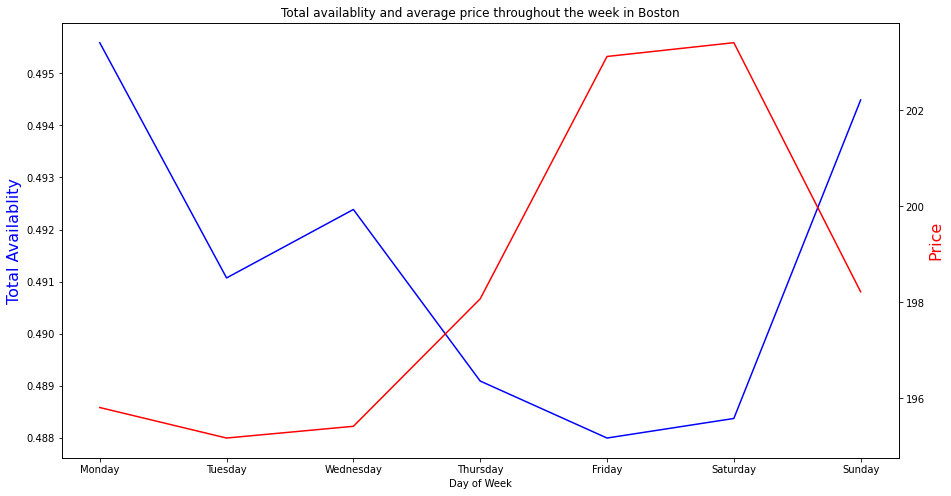

In [10]:
plt.figure(figsize=(15,8))

ax = sns.lineplot(data = availability_bos_dow, color="b")
ax2 = ax.twinx()
sns.lineplot(data=price_bos_dow, color="r", ax=ax2)
ax.set_ylabel('Total Availablity',fontsize=16,  color="b")
ax2.set_ylabel('Price', fontsize=16, color="r")
ax.set(xlabel="Day of Week", title="Total availablity and average price throughout the week in Boston")
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

We do the same for Seattle

[Text(0, 0, 'Monday'),
 Text(1, 0, 'Tuesday'),
 Text(2, 0, 'Wednesday'),
 Text(3, 0, 'Thursday'),
 Text(4, 0, 'Friday'),
 Text(5, 0, 'Saturday'),
 Text(6, 0, 'Sunday')]

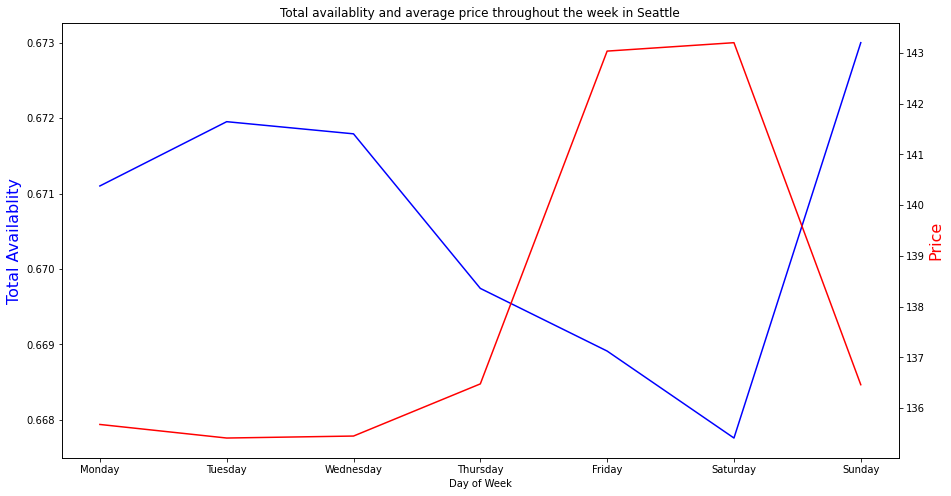

In [11]:
plt.figure(figsize=(15,8))

ax = sns.lineplot(data = availability_sea_dow, color="b")
ax2 = ax.twinx()
sns.lineplot(data=price_sea_dow, color="r", ax=ax2)
ax.set_ylabel('Total Availablity',fontsize=16,  color="b")
ax2.set_ylabel('Price', fontsize=16, color="r")
ax.set(xlabel="Day of Week", title="Total availablity and average price throughout the week in Seattle")
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

Then we will try to look into the availabity through out the year, therefore we create a new column "period" which combine the year and month.

In [12]:
df_cal_bos['period'] = df_cal_bos['year'].map(str)+ '-' +df_cal_bos['month'].map(str)
df_cal_sea['period'] = df_cal_sea['year'].map(str)+ '-' +df_cal_sea['month'].map(str)

In [13]:
df_cal_bos

,date,listing_id,available,price,year,month,day,dow,period
0,2017-09-05,12147973,0,NaN,2017,09,5,1,2017-09
1,2017-09-04,12147973,0,NaN,2017,09,4,0,2017-09
2,2017-09-03,12147973,0,NaN,2017,09,3,6,2017-09
3,2017-09-02,12147973,0,NaN,2017,09,2,5,2017-09
4,2017-09-01,12147973,0,NaN,2017,09,1,4,2017-09
...,...,...,...,...,...,...,...,...,...
1308885,2016-09-10,14504422,0,NaN,2016,09,10,5,2016-09
1308886,2016-09-09,14504422,0,NaN,2016,09,9,4,2016-09
1308887,2016-09-08,14504422,0,NaN,2016,09,8,3,2016-09
1308888,2016-09-07,14504422,0,NaN,2016,09,7,2,2016-09


In [14]:
#Showing the number of available listings on each period
availability_bos_period = get_availability(df_cal_bos, 'period')
availability_sea_period = get_availability(df_cal_sea, 'period')

In [15]:
#Combining the availablity of seattle and boston
period_availablity = pd.concat([availability_sea_period.rename('seattle availablity'), availability_bos_period.rename('boston availablity')], axis=1)

From the data, we know that both city have a different timeframe

In [16]:
period_availablity

,seattle availablity,boston availablity
2016-01,0.554133,NaN
2016-02,0.662208,NaN
2016-03,0.709187,NaN
2016-04,0.663847,NaN
2016-05,0.675670,NaN
2016-06,0.674384,NaN
2016-07,0.627097,NaN
2016-08,0.645051,NaN
2016-09,0.674402,0.272181
2016-10,0.696514,0.416899


Here we can see the trend of both city's availablity.

[Text(0.5, 0, 'Year-Month'),
 Text(0, 0.5, 'Total Availablity'),
 Text(0.5, 1.0, 'Total availablity throughout different months in Boston and Seattle')]

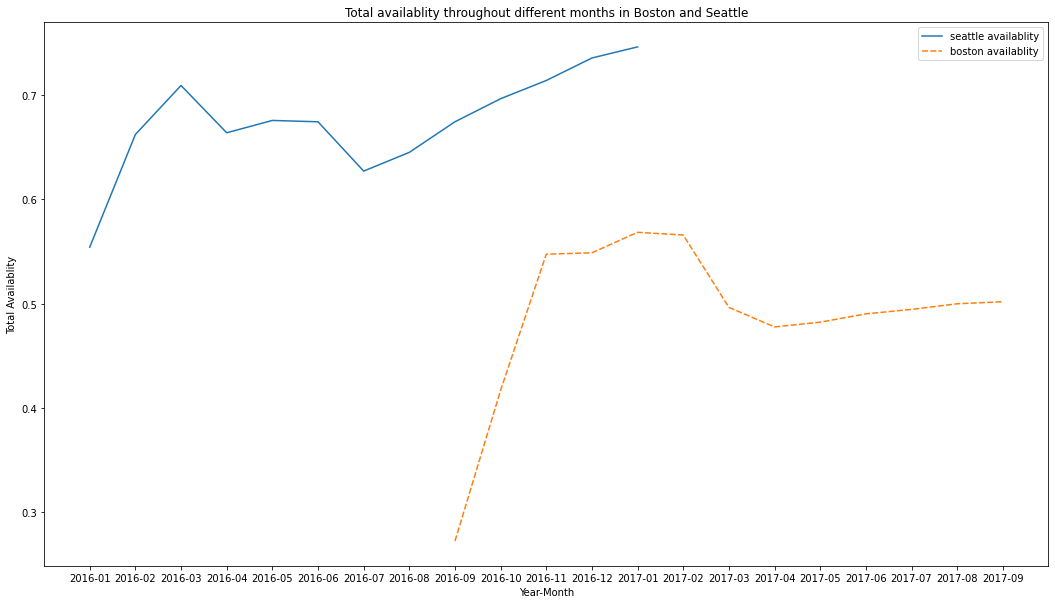

In [17]:
plt.figure(figsize=(18,10))

ax = sns.lineplot(data = period_availablity)
ax.set(xlabel="Year-Month",ylabel="Total Availablity", title="Total availablity throughout different months in Boston and Seattle")

In [18]:
price_bos_period = get_price(df_cal_bos, 'period')
price_sea_period = get_price(df_cal_sea, 'period')

In [19]:
period_price = pd.concat([price_sea_period.rename('seattle price'), price_bos_period.rename('boston price')], axis=1)

In [20]:
period_price

,seattle price,boston price
2016-01,121.568409,NaN
2016-02,124.293927,NaN
2016-03,128.644488,NaN
2016-04,135.097005,NaN
2016-05,139.538183,NaN
2016-06,147.473137,NaN
2016-07,152.094150,NaN
2016-08,150.656594,NaN
2016-09,143.255949,252.677308
2016-10,137.031939,233.416248


We can also see the trend of the price in both city

[Text(0.5, 0, 'Year-Month'),
 Text(0, 0.5, 'Average Price'),
 Text(0.5, 1.0, 'Average price throughout different months in Boston and Seattle')]

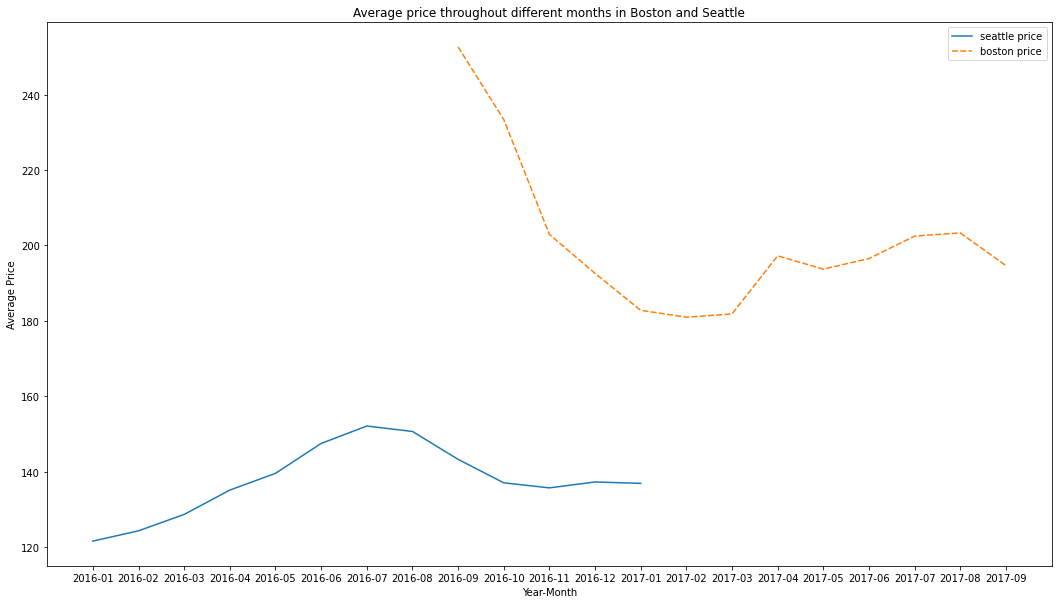

In [21]:
plt.figure(figsize=(18,10))

ax = sns.lineplot(data = period_price)
ax.set(xlabel="Year-Month",ylabel="Average Price", title="Average price throughout different months in Boston and Seattle")